In [1]:
### IMPORTS ###
import numpy as np
random_seed = 0
np.random.seed(random_seed)

## DISPLAY
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
plt.rcParams.update({'font.size': 30})

## TORCH
import torch
torch.manual_seed(42)
use_gpu = False

## LOCAL FILES
from code.generate_covariance_matrix import generate_covariance_matrix, display_COV
from code.spectral_estimation import beamforming_az
from code.utils import *
from code.model import Net

### FIXED PARAMETERS
Nz = 512 # number of discrete heights
min_z = -10 # minimum height
max_z = 30 # maximum height
az_out_sel = 115 # select one azimuth value for results display

Data loaded: dict_keys(['__header__', '__version__', '__globals__', 'k', 'kz'])


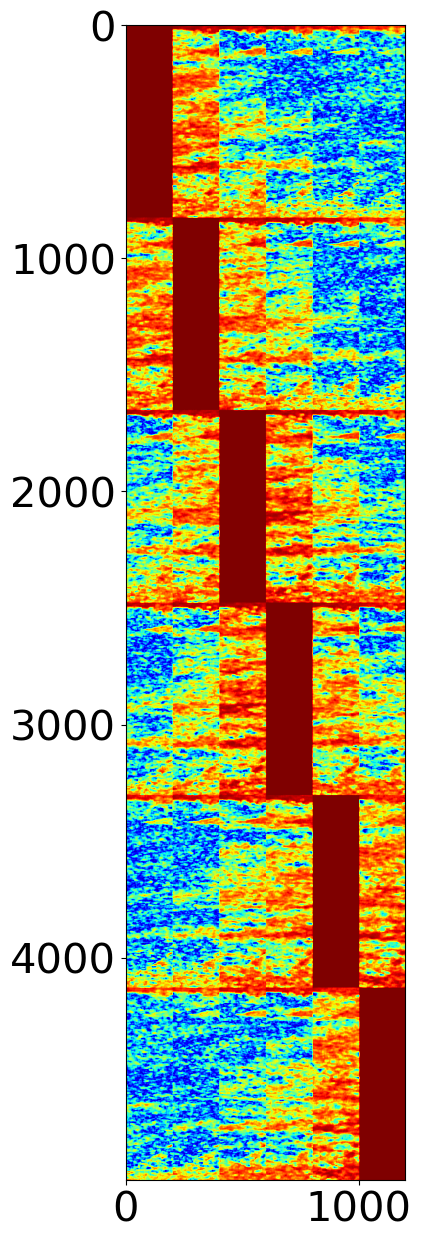

In [2]:
### LOAD AIRBORNE DATA
z = np.linspace(min_z, max_z, Nz) # heights
filename = "./data/Biosar2_sample200.mat"
I, kz, rg_ax, az_ax = load_mat_data(filename)

Wrg, Waz = 8, 17 # 60 looks
Cov, Corr = generate_covariance_matrix(I, az_ax, rg_ax, Waz, Wrg)
display_COV(Corr)

In [3]:
### compute input and feed it to the network         
bf = beamforming_az(Corr, az_out_sel, z=z, kz=kz, rg_ax=rg_ax)
net = Net(Nz, Nz, latent_space_size=5)

# load model
checkpoint = torch.load('./net_weights.pth')
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

with torch.no_grad():        
    # predict airborne tomogram
    bf_def_predicted = torch.transpose(torch.stack([net(torch.from_numpy(bf[:,i].astype(np.float32)).reshape(-1))[0] for i in range(len(rg_ax))]), 0, 1)

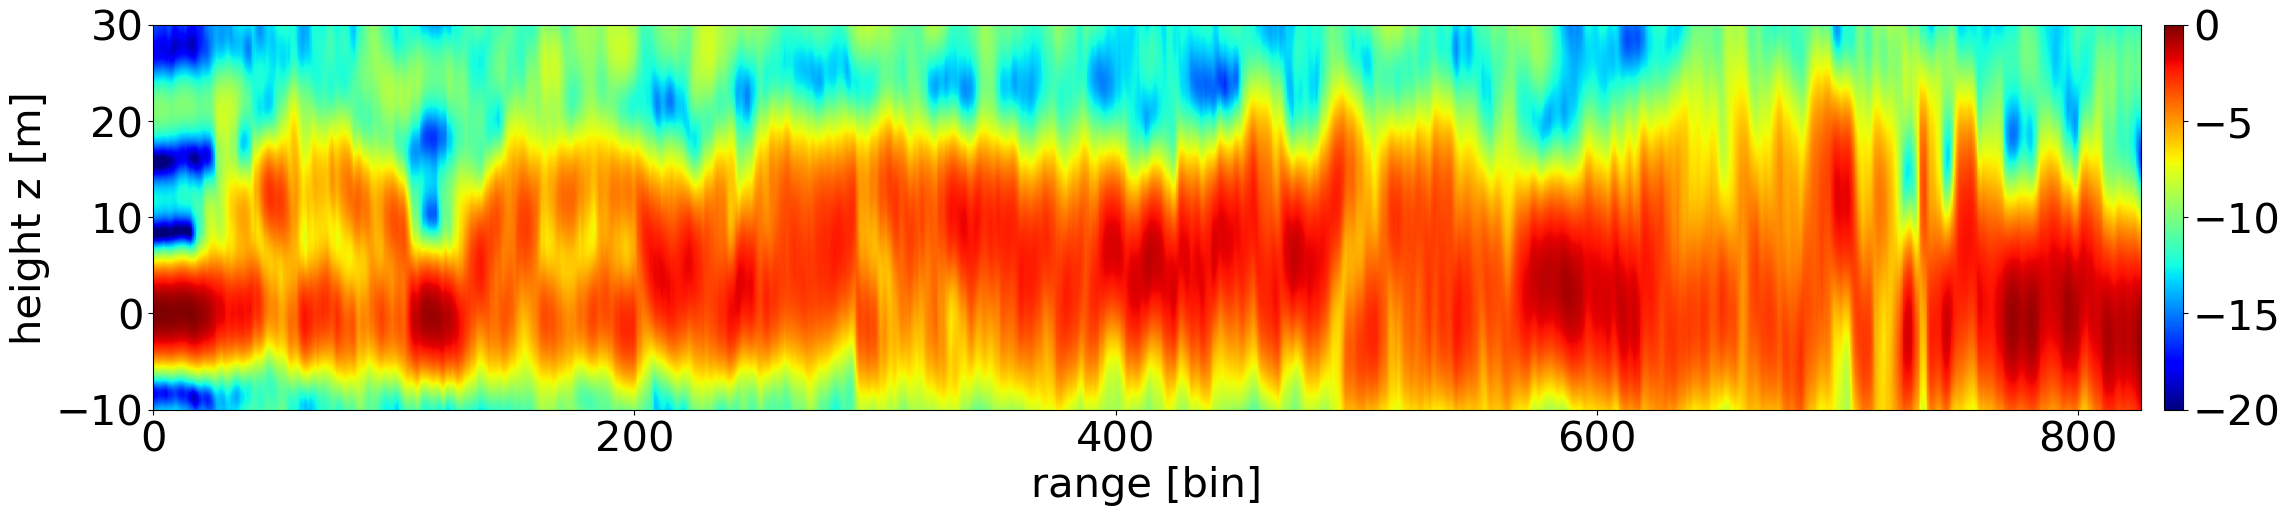

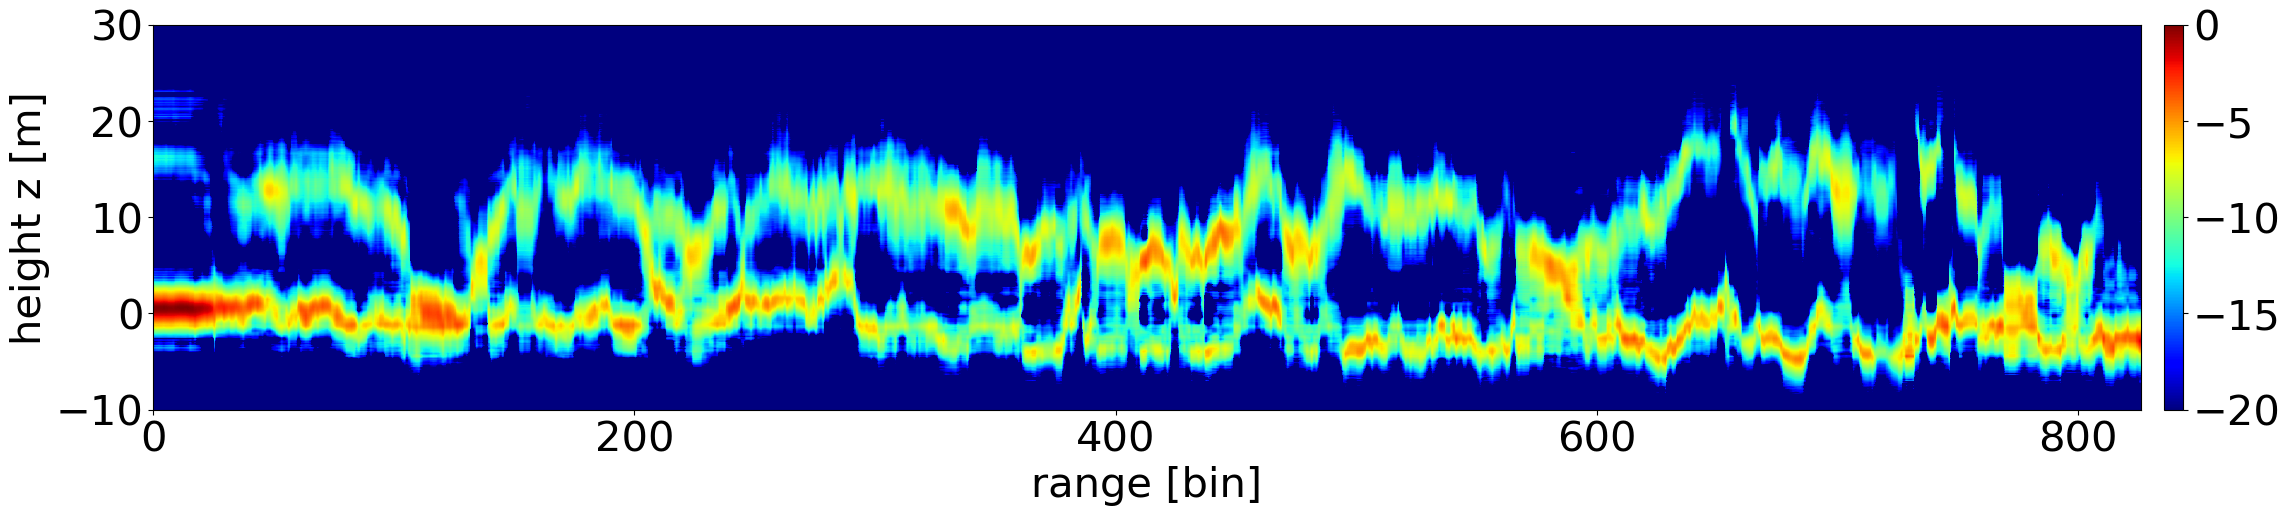

In [4]:
### display results
plot_dB(bf, z)
plot_dB(bf_def_predicted.detach().numpy(), z)
plt.show()